In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def wjaccard_on_dist(a, b):
    mn = np.sum(np.minimum(a[:,0], b[:,0]))
    mx = np.sum(np.maximum(a[:,0], b[:,0]))
    return mn/mx

def l1_on_dist(a, b):
    return np.sum(np.abs(a[:, 0] - b[:, 0]))


def attach_new_metric(df):
    new_metric = compute_metric(df, wjaccard_on_dist)
    df['wjaccard_dist_ksim'] = new_metric[:,0]
    df['wjaccard_dist_paa'] = new_metric[:,1]
    new_metric = compute_metric(df, l1_on_dist)
    df['l1_ksim'] = new_metric[:,0]
    df['l1_paa'] = new_metric[:,1]
    return df

prefix='../../results/'

df_ItalyPowerDemand = attach_new_metric(read_results_file(prefix + 'ksim_ItalyPowerDemand_0.1_results.txt'))
df_ItalyPowerDemand_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_ItalyPowerDemand_0.1_results.txt'))

df_ECG200 = attach_new_metric(read_results_file(prefix + 'ksim_ECG200_0.1_results.txt'))
df_ECG200_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_ECG200_0.1_results.txt'))

df_synthetic_control = attach_new_metric(read_results_file(prefix + 'ksim_synthetic_control_0.1_results.txt'))
df_synthetic_control_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_synthetic_control_0.1_results.txt'))

df_Gun_Point = attach_new_metric(read_results_file(prefix + 'ksim_Gun_Point_0.1_results.txt'))
df_Gun_Point_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_Gun_Point_0.1_results.txt'))

df_MedicalImages = attach_new_metric(read_results_file(prefix + 'ksim_MedicalImages_0.1_results.txt'))
df_MedicalImages_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_MedicalImages_0.1_results.txt'))

df_FaceAll = attach_new_metric(read_results_file(prefix + 'ksim_FaceAll_0.1_results.txt'))
df_FaceAll_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_FaceAll_0.1_results.txt'))

df_50words = attach_new_metric(read_results_file(prefix + 'ksim_50words_0.1_results.txt'))
df_50words_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_50words_0.1_results.txt'))


# Plot metrics of a few examples

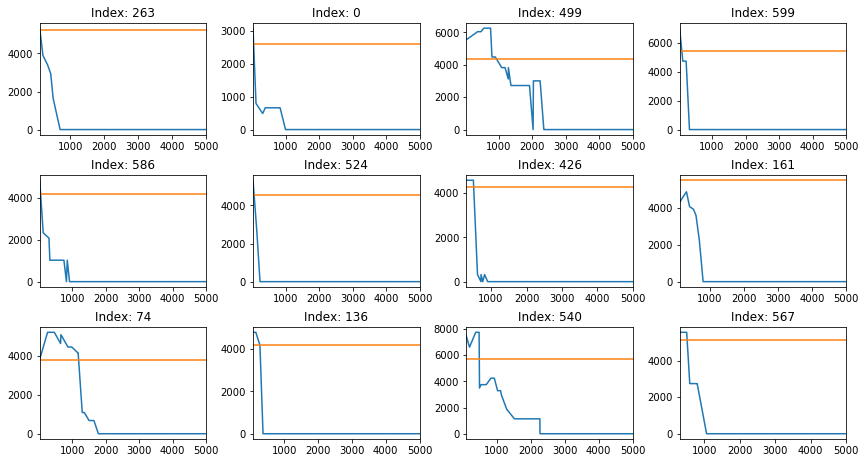

In [3]:
quick_view_metric(df_ItalyPowerDemand, metric='l1', title='', xlim=5000)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

# Report function

This function reports:
1. Accuracy
2. Percent of dataset need to be sought to reach 100% accuracy

Figures are saved to file

In [4]:
def report(df, df_out, title, xlim=5000, in_or_out='both'):
    if in_or_out == 'both':
        plt.figure(figsize=(8, 7))
        ax1 = plt.subplot(2, 1, 1)
    if in_or_out in ['both', 'in']:
        report_accuracy(df, title=title + ' (in-dataset)', k=1, xlim=xlim)
        report_accuracy(df, title=title + ' (in-dataset)', k=9, xlim=xlim)
        report_accuracy(df, title=title + ' (in-dataset)', k=15, xlim=xlim)
        
    if in_or_out == 'both':
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    if in_or_out in ['both', 'out']:        
        report_accuracy(df_out, title=title + ' (out-of-dataset)', k=1, xlim=xlim)
        report_accuracy(df_out, title=title + ' (out-of-dataset)', k=9, xlim=xlim)
        report_accuracy(df_out, title=title + ' (out-of-dataset)', k=15, xlim=xlim)

    if in_or_out == 'both':
        plt.tight_layout()
        plt.savefig("accuracy_%s.eps" % title)

ItalyPowerDemand (in-dataset) k = 1
 max accuracy: 162.375000
 min extent: 8
 max PAA accuracy: 0.000000
ItalyPowerDemand (in-dataset) k = 9
 max accuracy: 3150.725000
 min extent: 71
 max PAA accuracy: 2698.138833
ItalyPowerDemand (in-dataset) k = 15
 max accuracy: 5058.625000
 min extent: 142
 max PAA accuracy: 4736.219110
ECG200 (in-dataset) k = 1
 max accuracy: 4.400000
 min extent: 1
 max PAA accuracy: 0.000000
ECG200 (in-dataset) k = 9
 max accuracy: 101.075000
 min extent: 14
 max PAA accuracy: 7.735849
ECG200 (in-dataset) k = 15
 max accuracy: 191.250000
 min extent: 32
 max PAA accuracy: 19.563869
synthetic_control (in-dataset) k = 1
 max accuracy: 0.000000
 min extent: 1
 max PAA accuracy: 0.000000
synthetic_control (in-dataset) k = 9
 max accuracy: 0.000000
 min extent: 9
 max PAA accuracy: 15.050000
synthetic_control (in-dataset) k = 15
 max accuracy: 0.000000
 min extent: 15
 max PAA accuracy: 69.825000
Gun_Point (in-dataset) k = 1
 max accuracy: 3.880000
 min extent: 1
 m

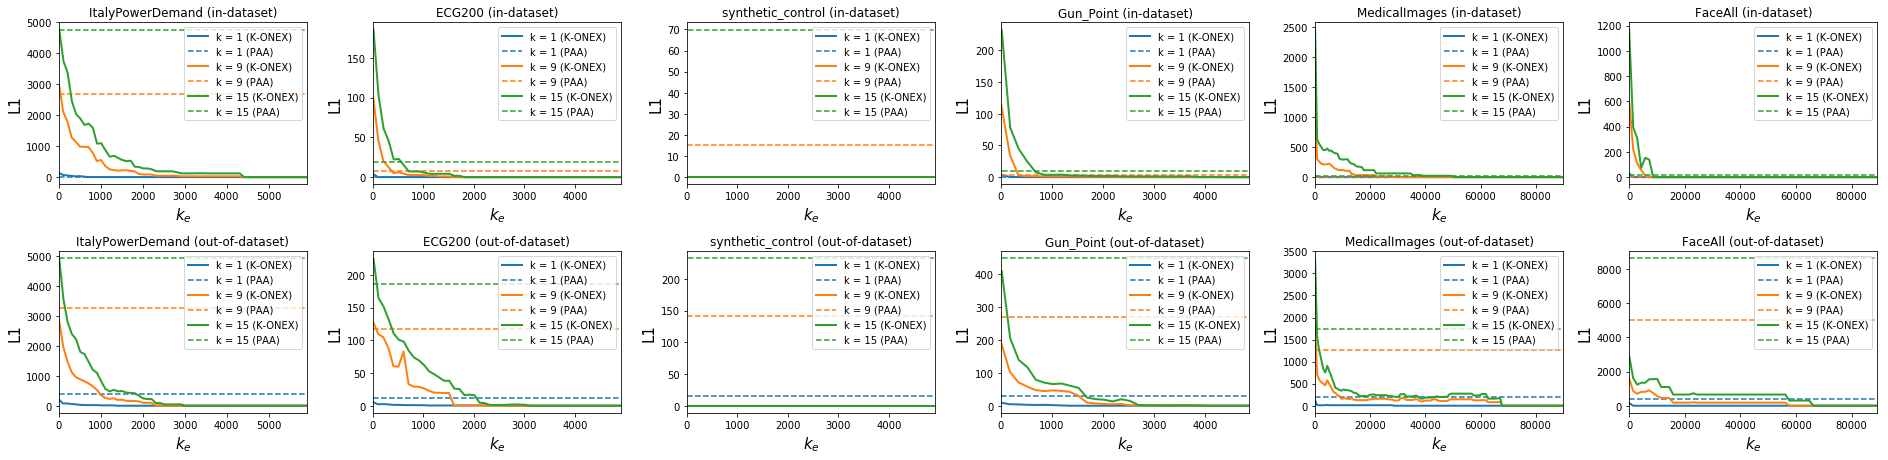

In [5]:
plt.figure(figsize=(35, 6.5))
plt.subplot(2, 8, 1)
report(df_ItalyPowerDemand, df_ItalyPowerDemand_out, 'ItalyPowerDemand', xlim=6000, in_or_out='in')
plt.subplot(2, 8, 2)
report(df_ECG200, df_ECG200_out, 'ECG200', in_or_out='in')
plt.subplot(2, 8, 3)
report(df_synthetic_control, df_synthetic_control_out, 'synthetic_control', in_or_out='in')
plt.subplot(2, 8, 4)
report(df_Gun_Point, df_Gun_Point_out, 'Gun_Point', in_or_out='in')
plt.subplot(2, 8, 5)
report(df_MedicalImages, df_MedicalImages_out, 'MedicalImages', xlim=90000, in_or_out='in')
plt.subplot(2, 8, 6)
report(df_FaceAll, df_FaceAll_out, 'FaceAll', xlim=90000, in_or_out='in')
plt.subplot(2, 8, 9)
report(df_ItalyPowerDemand, df_ItalyPowerDemand_out, 'ItalyPowerDemand', xlim=6000, in_or_out='out')
plt.subplot(2, 8, 10)
report(df_ECG200, df_ECG200_out, 'ECG200', in_or_out='out')
plt.subplot(2, 8, 11)
report(df_synthetic_control, df_synthetic_control_out, 'synthetic_control', in_or_out='out')
plt.subplot(2, 8, 12)
report(df_Gun_Point, df_Gun_Point_out, 'Gun_Point', in_or_out='out')
plt.subplot(2, 8, 13)
report(df_MedicalImages, df_MedicalImages_out, 'MedicalImages', xlim=90000, in_or_out='out')
plt.subplot(2, 8, 14)
report(df_FaceAll, df_FaceAll_out, 'FaceAll', xlim=90000, in_or_out='out')
plt.tight_layout()
plt.savefig('accuracy_all_datasets.eps')

# ItalyPowerDemand

ItalyPowerDemand (in-dataset) k = 1
 max accuracy: 162.375000
 min extent: 8
 max PAA accuracy: 0.000000
ItalyPowerDemand (in-dataset) k = 9
 max accuracy: 3150.725000
 min extent: 71
 max PAA accuracy: 2698.138833
ItalyPowerDemand (in-dataset) k = 15
 max accuracy: 5058.625000
 min extent: 142
 max PAA accuracy: 4736.219110
ItalyPowerDemand (out-of-dataset) k = 1
 max accuracy: 238.725000
 min extent: 6
 max PAA accuracy: 390.166667
ItalyPowerDemand (out-of-dataset) k = 9
 max accuracy: 3026.150000
 min extent: 41
 max PAA accuracy: 3252.857143
ItalyPowerDemand (out-of-dataset) k = 15
 max accuracy: 5174.475000
 min extent: 87
 max PAA accuracy: 4927.865209


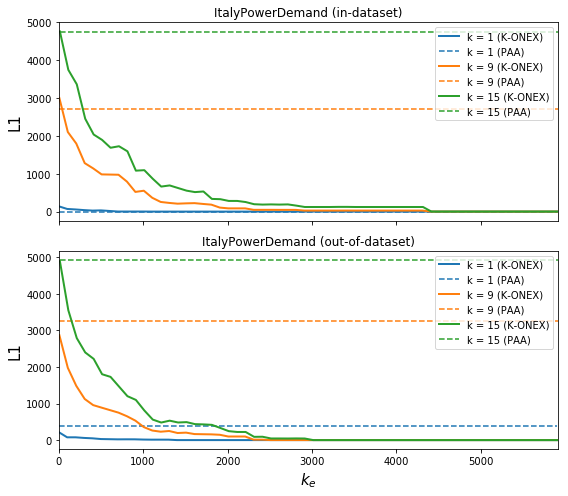

In [6]:
report(df_ItalyPowerDemand, df_ItalyPowerDemand_out, 'ItalyPowerDemand', xlim=6000)

# ECG200

ECG200 (in-dataset) k = 1
 max accuracy: 4.400000
 min extent: 1
 max PAA accuracy: 0.000000
ECG200 (in-dataset) k = 9
 max accuracy: 101.075000
 min extent: 14
 max PAA accuracy: 7.735849
ECG200 (in-dataset) k = 15
 max accuracy: 191.250000
 min extent: 32
 max PAA accuracy: 19.563869
ECG200 (out-of-dataset) k = 1
 max accuracy: 6.366667
 min extent: 14
 max PAA accuracy: 11.936330
ECG200 (out-of-dataset) k = 9
 max accuracy: 144.700000
 min extent: 29
 max PAA accuracy: 117.740741
ECG200 (out-of-dataset) k = 15
 max accuracy: 257.300000
 min extent: 145
 max PAA accuracy: 185.183849


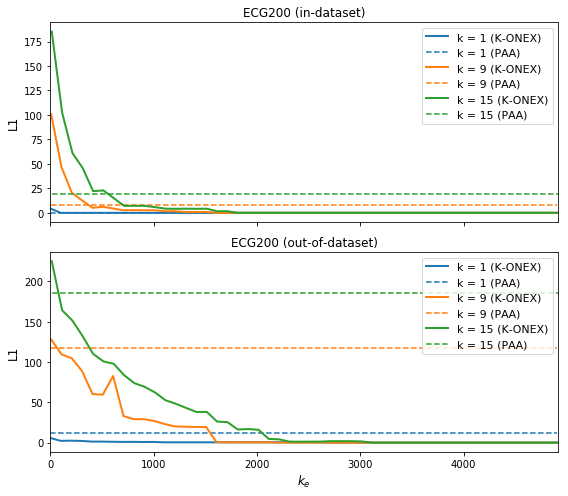

In [387]:
report(df_ECG200, df_ECG200_out, 'ECG200')

# synthetic_control

synthetic_control (in-dataset) k = 1
 max accuracy: 0.000000
 min extent: 1
 max PAA accuracy: 0.000000
synthetic_control (in-dataset) k = 9
 max accuracy: 0.000000
 min extent: 9
 max PAA accuracy: 15.050000
synthetic_control (in-dataset) k = 15
 max accuracy: 0.000000
 min extent: 15
 max PAA accuracy: 69.825000
synthetic_control (out-of-dataset) k = 1
 max accuracy: 0.000000
 min extent: 1
 max PAA accuracy: 16.000000
synthetic_control (out-of-dataset) k = 9
 max accuracy: 0.000000
 min extent: 9
 max PAA accuracy: 141.300000
synthetic_control (out-of-dataset) k = 15
 max accuracy: 0.000000
 min extent: 15
 max PAA accuracy: 232.200000


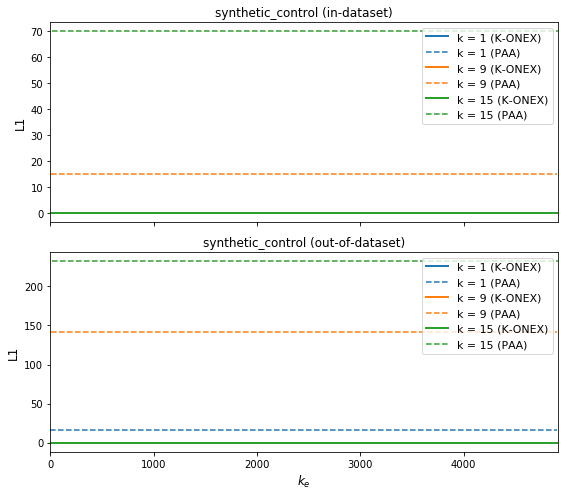

In [388]:
report(df_synthetic_control, df_synthetic_control_out, 'synthetic_control')

# Gun_Point

Gun_Point (in-dataset) k = 1
 max accuracy: 3.880000
 min extent: 1
 max PAA accuracy: 0.000000
Gun_Point (in-dataset) k = 9
 max accuracy: 113.040000
 min extent: 9
 max PAA accuracy: 3.348457
Gun_Point (in-dataset) k = 15
 max accuracy: 232.880000
 min extent: 21
 max PAA accuracy: 10.033727
Gun_Point (out-of-dataset) k = 1
 max accuracy: 9.320000
 min extent: 1
 max PAA accuracy: 30.081481
Gun_Point (out-of-dataset) k = 9
 max accuracy: 210.320000
 min extent: 35
 max PAA accuracy: 268.596100
Gun_Point (out-of-dataset) k = 15
 max accuracy: 425.240000
 min extent: 35
 max PAA accuracy: 448.129973


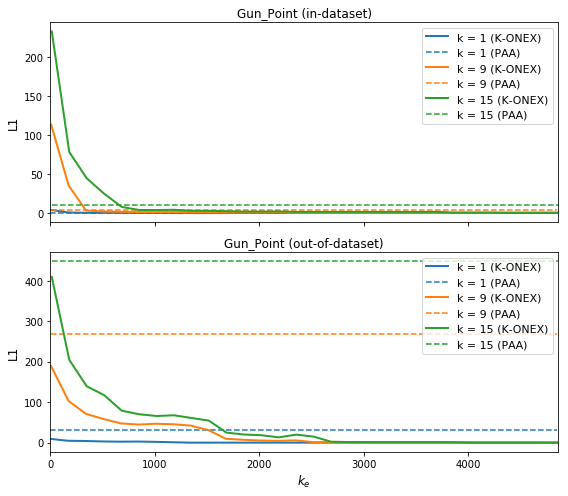

In [389]:
report(df_Gun_Point, df_Gun_Point_out, 'Gun_Point')

# MedicalImages

MedicalImages (in-dataset) k = 1
 max accuracy: 20.800000
 min extent: 30
 max PAA accuracy: 0.000000
MedicalImages (in-dataset) k = 9
 max accuracy: 1277.200000
 min extent: 9
 max PAA accuracy: 0.000000
MedicalImages (in-dataset) k = 15
 max accuracy: 2458.760000
 min extent: 15
 max PAA accuracy: 12.695958
MedicalImages (out-of-dataset) k = 1
 max accuracy: 129.960000
 min extent: 1
 max PAA accuracy: 207.746575
MedicalImages (out-of-dataset) k = 9
 max accuracy: 1916.360000
 min extent: 1394
 max PAA accuracy: 1263.274648
MedicalImages (out-of-dataset) k = 15
 max accuracy: 3499.520000
 min extent: 2461
 max PAA accuracy: 1750.722222


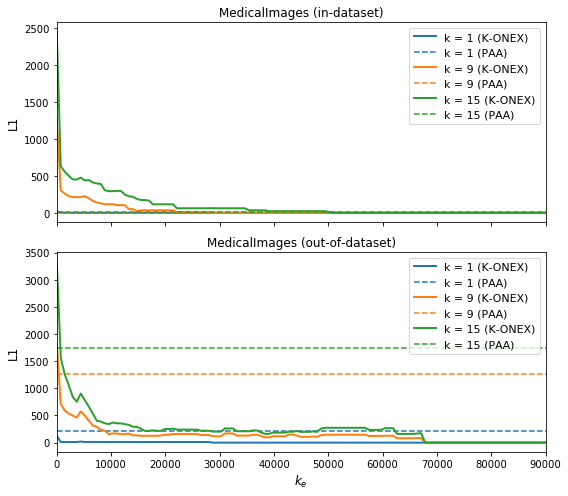

In [390]:
report(df_MedicalImages, df_MedicalImages_out, 'MedicalImages', xlim=90000)

# FaceAll

FaceAll (in-dataset) k = 1
 max accuracy: 29.500000
 min extent: 1
 max PAA accuracy: 0.000000
FaceAll (in-dataset) k = 9
 max accuracy: 637.500000
 min extent: 152
 max PAA accuracy: 3.873874
FaceAll (in-dataset) k = 15
 max accuracy: 1167.100000
 min extent: 15
 max PAA accuracy: 12.966102
FaceAll (out-of-dataset) k = 1
 max accuracy: 162.400000
 min extent: 1
 max PAA accuracy: 370.745763
FaceAll (out-of-dataset) k = 9
 max accuracy: 1630.100000
 min extent: 152
 max PAA accuracy: 5013.290909
FaceAll (out-of-dataset) k = 15
 max accuracy: 2940.000000
 min extent: 1022
 max PAA accuracy: 8622.094017


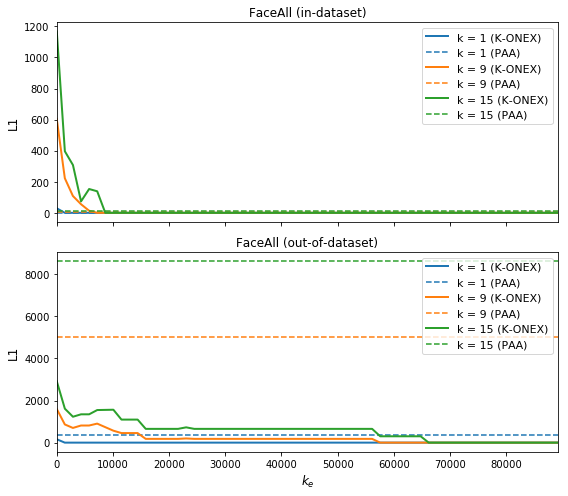

In [391]:
report(df_FaceAll, df_FaceAll_out, 'FaceAll', xlim=90000)

# 50Words

ts_index    420
ts_start    200
ts_end      269
Name: 246, dtype: int64 [   1 1653 3305 4957 6609 8261 9913]
ts_index     38
ts_start    124
ts_end      220
Name: 253, dtype: int64 [    1  1653  3305  4957  6609  8261  9913 11565 13217 14869 16521 18173
 19825 21477 23129 24781 26433]
ts_index    241
ts_start     27
ts_end      122
Name: 270, dtype: int64 [    1  1653  3305  4957  6609  8261  9913 11565 13217 14869 16521 18173
 19825 21477 23129 24781]
ts_index    202
ts_start     46
ts_end      181
Name: 286, dtype: int64 [   1 1653 3305 4957 6609 8261]
ts_index     11
ts_start     18
ts_end      215
Name: 292, dtype: int64 [   1 1653 3305 4957 6609 8261]
ts_index    191
ts_start    108
ts_end      243
Name: 298, dtype: int64 [   1 1653 3305 4957 6609]
ts_index    163
ts_start     12
ts_end      227
Name: 303, dtype: int64 [   1 1653 3305 4957 6609]
ts_index    268
ts_start    138
ts_end      243
Name: 308, dtype: int64 [    1  1653  3305  4957  6609  8261  9913 11565 13217 14869 1652

IndexError: index 1 is out of bounds for axis 0 with size 1

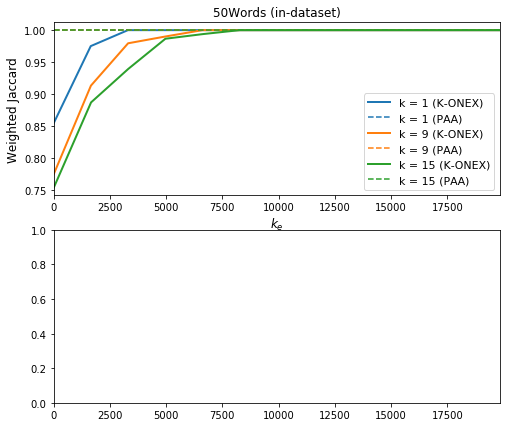

In [352]:
report(df_50words, df_50words_out, '50Words', xlim=20000)